In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0
    return diff

def one_d_array_to_predicitons(one_d_array, times):
    return np.repeat(one_d_array.reshape((-1, 1)), times, axis=1)

def calculate_momentum(time_series_arr, alpha, trend):
    last_count = time_series_arr[:, 1]
    count_nans = np.isnan(last_count)
    last_count[count_nans] = time_series_arr[count_nans, 0]
    
    medians = np.nanmedian(time_series_arr, axis=1)
    count_nans = np.isnan(last_count)
    last_count[count_nans] = medians[count_nans]
    
    last_momentum = time_series_arr[:, 1] - time_series_arr[:, 0]
    count_nans = np.isnan(last_momentum)
    last_momentum[count_nans] = 0
    
    for i in range(2, time_series_arr.shape[1]):
        count = alpha * time_series_arr[:, i] + (1-alpha) * (last_count + last_momentum)
        count_nans = np.isnan(time_series_arr[:, i])
        count[count_nans] = last_count[count_nans]
        
        momentum = trend * (count - last_count) + (1-trend) * (last_momentum)
        count_nans = np.isnan(time_series_arr[:, i])
        momentum[count_nans] = last_momentum[count_nans]
        
        last_count = count
        last_momentum = momentum
        
    return count, momentum
        

In [20]:
train = pd.DataFrame.from_csv('train_1.csv')
days_evaluation = 90
evaluation = train.iloc[:, -1*days_evaluation:]
local_train = train.iloc[:, : -1*days_evaluation]

In [88]:
prediction_days = 50
prediction_rows = np.nanmedian(local_train.values[:, -1*prediction_days:], axis=1)
all_nans = np.isnan(prediction_rows)
prediction_rows[all_nans] = 300
predictions = one_d_array_to_predicitons(prediction_rows, days_evaluation)

2953


/home/yair/.local/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:769: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [89]:
train_logs = np.log(1+local_train.values)
prediction_log_rows = np.nanmedian(train_logs[:, -1*prediction_days:], axis=1)
prediction_log_rows = np.exp(prediction_log_rows)-1
prediction_log_rows[all_nans] = 300
prediction_log_rows = prediction_log_rows.astype(int)

/home/yair/.local/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:769: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [90]:
count, momentum = calculate_momentum(train.values, 0.1, 0.01)
count[all_nans] = 300
count = count.astype(int)
count[count < 0] = 0

print(np.nanmean(smape(evaluation.values, predictions)))
print(np.nanmean(smape(evaluation.values, one_d_array_to_predicitons(count, days_evaluation))))
print(np.nanmean(smape(evaluation.values, one_d_array_to_predicitons(prediction_log_rows, days_evaluation))))

/home/yair/.local/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:717: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


50.3063972983


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


55.3142140394
50.5186060807


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


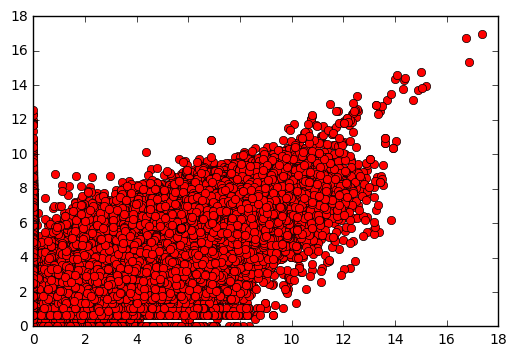

In [48]:
plt.plot(np.log(1+count), np.log(1+prediction_rows), 'ro')
plt.show()

In [71]:
smape_holt_row_score = np.nanmean(smape(evaluation.values, one_d_array_to_predicitons(count, days_evaluation)), axis=1)
smape_median_row_score = np.nanmean(smape(evaluation.values, one_d_array_to_predicitons(prediction_rows, days_evaluation)), axis=1)

not_nan_rows = ~np.isnan(smape_holt_row_score)

smape_holt_row_score = smape_holt_row_score[not_nan_rows]
smape_median_row_score = smape_median_row_score[not_nan_rows]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/yair/.local/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/yair/.local/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


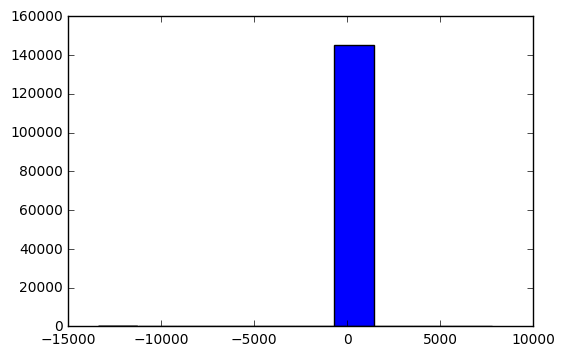

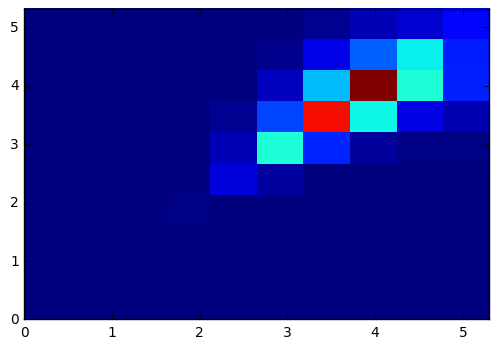

In [81]:
plt.hist(momentum)
plt.show()

"""Error of holt vs median"""
plt.hist2d(np.log(1+smape_holt_row_score), np.log(1+smape_median_row_score))
plt.show()

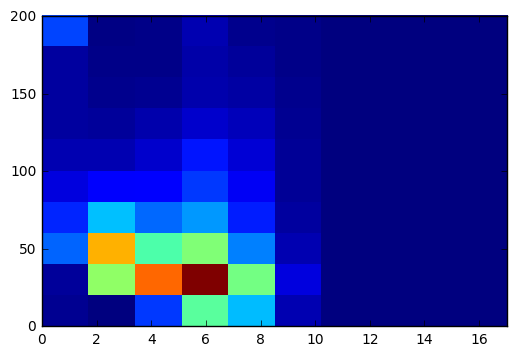

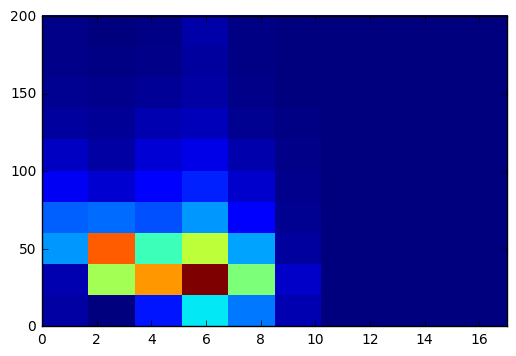

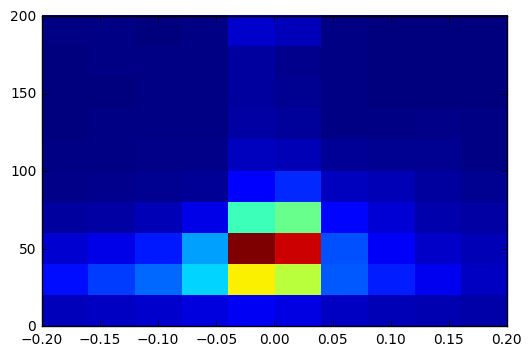

In [80]:
plt.hist2d(np.log(1+count[not_nan_rows]), smape_holt_row_score)
plt.show()
plt.hist2d(np.log(1+prediction_rows[not_nan_rows]), smape_median_row_score)
plt.show()
plt.hist2d(momentum[not_nan_rows], smape_holt_row_score, range=[[-0.2, 0.2], [0, 200]])
plt.show()